In [14]:
import pickle
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline

## Load Unique Data

In [2]:
files = ["scidir_metadata_2000.p", "scidir_metadata_2000.p", "scidir_metadata_4950.p"]

rest = []
final = pickle.load(open("scidir_metadata/" + files[0], "rb"))[1]

for file in files[1:]:
    rest.extend(pickle.load(open("scidir_metadata/" + file, "rb"))[1])
    
print(len(final), len(rest))

1956 6904


In [3]:
prev_len_final = len(final) - 1

while prev_len_final != len(final):
    final_ids = [x.id for x in final]
    for each in rest:
        if each.id not in final_ids:
            final.append(each)
    prev_len_final = len(final)
    print(len(final))

4952


## Extracting Useful Data

In [4]:
data = [x.data["coredata"] for x in final]
temp = data[62]
temp.keys()
# print(temp["prism:issueName"])
# print(temp["prism:aggregationType"])

dict_keys(['pii', 'eid', 'pubType', 'prism:copyright', 'prism:pageRange', 'dc:title', 'prism:issn', 'dc:description', 'link', 'prism:publisher', 'dc:identifier', 'dc:format', 'openArchiveArticle', 'openaccess', 'prism:startingPage', 'prism:url', 'openaccessUserLicense', 'openaccessArticle', 'prism:coverDate', 'prism:doi', 'openaccessType', 'openaccessSponsorName', 'dcterms:subject', 'prism:aggregationType', 'openaccessSponsorType', 'prism:volume', 'prism:publicationName', 'prism:coverDisplayDate', 'prism:endingPage'])

### Testing cell
keep_list = ['pubType', 'dc:title', 'dc:description', 'prism:publisher', 'openaccess', 'dc:creator',
             'prism:coverDate', 'prism:issueName', 'prism:doi', 'openaccessType', 'openaccessSponsorName',
             'prism:aggregationType', 'openaccessSponsorType', 'prism:publicationName']

```
temp.keys()
for key in temp.keys():
    if key in keep_list:
        print(key, temp[key])
        break
```

In [6]:
articles = list()

for dat in data:
    try:
        article_dict = dict()
    #     article_dict["pub_type"] = dat["pubType"]
        article_dict["title"] = dat["dc:title"]
        article_dict["abstract"] = dat["dc:description"]
#         article_dict["publisher"] = dat["prism:publisher"]
#         article_dict["authors"] = [author["$"] for author in dat["dc:creator"]]
        article_dict["cover_date"] = dat["prism:coverDate"]
    #     article_dict["issue_name"] = dat["prism:issueName"]
        article_dict["doi"] = dat["prism:doi"]
        article_dict["open_access"] = dat["openaccess"]
        article_dict["open_access_type"] = dat["openaccessType"]
        article_dict["open_access_sponsor_name"] = dat["openaccessSponsorName"]
        article_dict["type"] = dat["prism:aggregationType"]
        article_dict["open_access_sponsor_type"] = dat["openaccessSponsorType"]
        article_dict["publication_name"] = dat["prism:publicationName"]
    except KeyError as key:
        print(key)
    
    articles.append(article_dict)

## Analysis

In [7]:
df = pd.DataFrame(articles)

In [9]:
df.columns

Index(['abstract', 'cover_date', 'doi', 'open_access',
       'open_access_sponsor_name', 'open_access_sponsor_type',
       'open_access_type', 'publication_name', 'title', 'type'],
      dtype='object')

In [12]:
abstracts = " ".join([abstract for abstract in list(df.abstract) if abstract is not None])

In [15]:
print(len(abstracts))

4714622


In [18]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [24]:
temp = word_tokenize(abstracts)
word_tokens = []

for tem in temp:
    if len(tem) > 2:
        word_tokens.append(lemmatizer.lemmatize(tem.lower()))


In [42]:
words_to_ignore = "wa,used,using,paper,based,study,approach,ha,method,result,problem,proposed,abstract,performance,technique,process,different,two,new,research,parameter,application,also,time,set,use,one,developed,design,show,value,information,knowledge,model,system,present,compared,solution,experimental,obtained"

stop_words = stopwords.words("english")
stop_words += words_to_ignore.split(",")

words = [w for w in word_tokens if not w in stop_words]

In [43]:
freq = nltk.FreqDist(words)

freq.most_common(20)

[('artificial', 3991),
 ('network', 3838),
 ('algorithm', 3188),
 ('neural', 2920),
 ('data', 2896),
 ('intelligence', 2632),
 ('ann', 2161),
 ('analysis', 1355),
 ('prediction', 1129),
 ('optimization', 1100),
 ('control', 1038),
 ('learning', 933),
 ('function', 868),
 ('input', 865),
 ('accuracy', 857),
 ('test', 793),
 ('training', 792),
 ('number', 780),
 ('work', 770),
 ('tool', 756)]

In [59]:
for i, date in enumerate(df.cover_date):
    df.cover_date[i] = int(date[:4])
#     years.append(year)
df.cover_date

TypeError: 'int' object is not subscriptable

In [66]:
def process_abstracts(temp_df):
    abstracts = " ".join([abstract for abstract in list(temp_df.abstract) if abstract is not None])
    temp = word_tokenize(abstracts)
    word_tokens = []

    for tem in temp:
        if len(tem) > 2:
            word_tokens.append(lemmatizer.lemmatize(tem.lower()))
    
    words_to_ignore = "wa,used,using,paper,based,study,approach,ha,method,result,problem,proposed,abstract,performance,technique,process,different,two,new,research,parameter,application,also,time,set,use,one,developed,design,show,value,information,knowledge,model,system,present,compared,solution,experimental,obtained"

    stop_words = stopwords.words("english")
    stop_words += words_to_ignore.split(",")

    words = [w for w in word_tokens if not w in stop_words]
    
    return words

In [93]:
def word_frequency(df, word):
    year = 1961
    x = []
    y = []

    while year <= 2018:
        temp_df = df[df.cover_date == year]
        words = process_abstracts(temp_df)
        freq = nltk.FreqDist(words)
        try:
            y.append(freq[word] / len(temp_df))
        except ZeroDivisionError:
            y.append(freq[word])
        x.append(year)
        year += 1
    
    return x, y

def open_access(df):
    year = 1961
    x = []
    y = []

    while year <= 2018:
        temp_df = df[df.cover_date == year]
        try:
            y.append(sum(temp_df.open_access.astype("int64")) / len(temp_df))
        except ZeroDivisionError:
            y.append(sum(temp_df.open_access.astype("int64")))
        x.append(year)
        year += 1
    
    return x, y

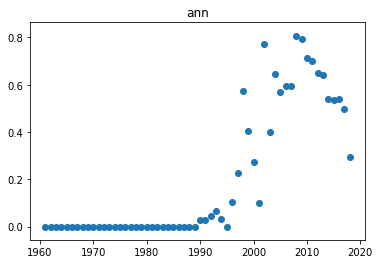

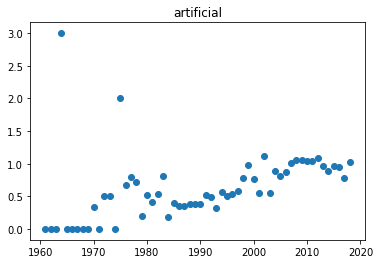

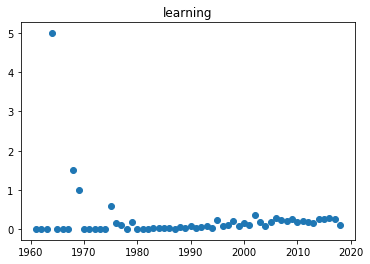

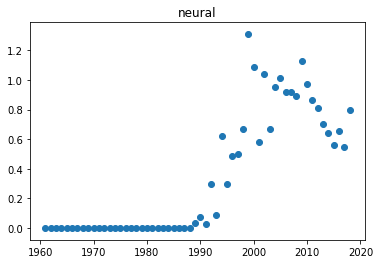

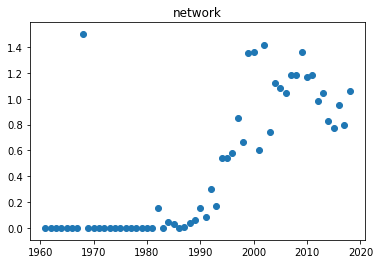

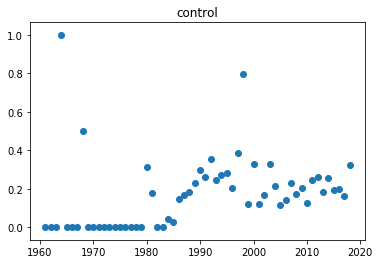

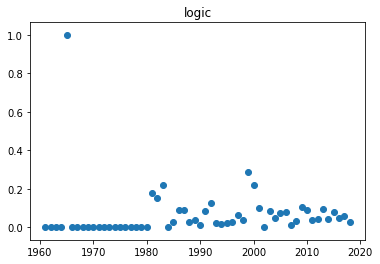

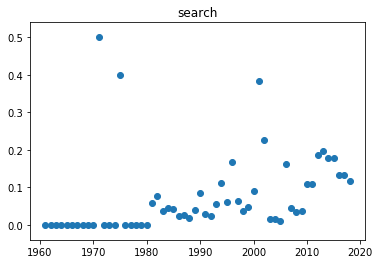

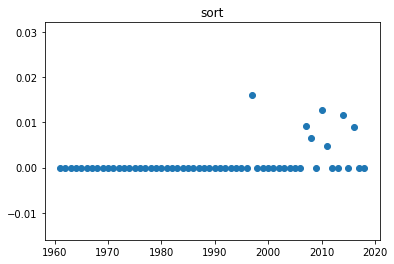

In [123]:
plot_list = "ann,artificial,learning,neural,network,control,logic,search,sort"
for each in plot_list.split(","):
    x, y = word_frequency(df, each)
    plt.figure()
    plt.scatter(x, y)
    plt.title(each)
    plt.show()

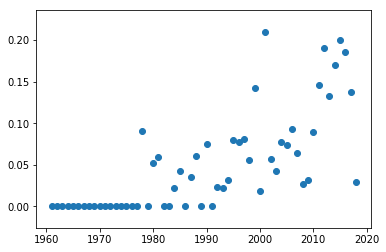

In [94]:
x, y = open_access(df)
plt.figure()
plt.scatter(x, y)
plt.show()

In [111]:
from collections import Counter as c
# sum(df.open_access.astype("int64"))
# len(df.open_access) - sum(df.open_access.astype("int64"))
a = c(df.open_access_sponsor_type)
print(a)

Counter({None: 4447, 'ElsevierWaived': 221, 'ElsevierBranded': 158, 'FundingBody': 96, 'Author': 26, 'FundingPartnerOpenArchive': 3, 'Other': 1})


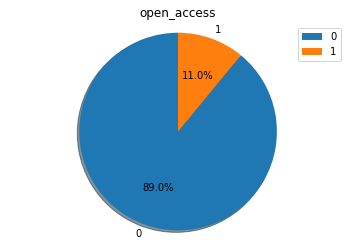

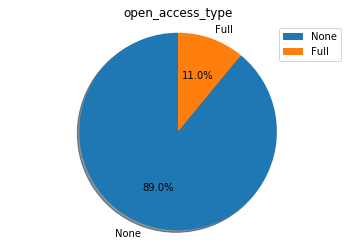

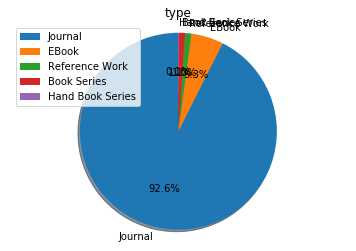

In [126]:
from collections import Counter as c

cols = "open_access,open_access_type,type"
for column in cols.split(","):
    labels = []
    sizes = []
    
    temp = c(df[column])
    
    for key in temp.keys():
        labels.append(key)
        sizes.append(temp[key])

    plt.figure()
    patches, texts, _ = plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(column)

    plt.show()

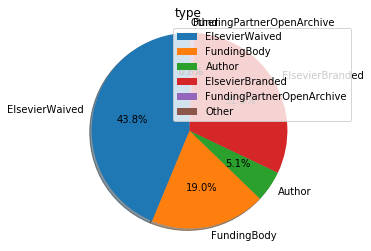

In [129]:
labels = []
sizes = []

temp = c(filter(None, list(df["open_access_sponsor_type"])))

for key in temp.keys():
    labels.append(key)
    sizes.append(temp[key])

plt.figure()
patches, texts, _ = plt.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(patches, labels, loc=0)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(column)

plt.show()